In [2]:
import sys
import gensim, logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors

In [3]:
import zipfile
import wget
import gensim

model_url = 'http://vectors.nlpl.eu/repository/20/220.zip'
m = wget.download(model_url)
model_file = model_url.split('/')[-1]

with zipfile.ZipFile(model_file, 'r') as archive:
    with archive.open('model.bin') as stream:
        model_data = stream.read()

with open('temp_model.bin', 'wb') as f:
    f.write(model_data)

model = gensim.models.KeyedVectors.load_word2vec_format('temp_model.bin', binary=True)

import os
os.remove('temp_model.bin')

100% [......................................................................] 638171816 / 638171816

2024-10-04 13:01:17,042 : INFO : loading projection weights from temp_model.bin
2024-10-04 13:01:21,885 : INFO : KeyedVectors lifecycle event {'msg': 'loaded (249333, 300) matrix of type float32 from temp_model.bin', 'binary': True, 'encoding': 'utf8', 'datetime': '2024-10-04T13:01:21.885789', 'gensim': '4.3.3', 'python': '3.9.13 (tags/v3.9.13:6de2ca5, May 17 2022, 16:36:42) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19045-SP0', 'event': 'load_word2vec_format'}


In [4]:
with open('HW2_change.txt', 'r', encoding='utf-8') as f:
    lines = f.readlines()

pairs = dict()
for line in lines:
    verb = line.split()[0]
    noun = line.split()[1]
    if verb in pairs.keys():
        pairs[verb].append(noun)
    else:
        pairs[verb] = [noun]

In [5]:
words_vect = dict()
for verb in list(pairs.keys()):
    words_vect[verb] =  model[verb + '_VERB']
    vals = []
    for noun in pairs[verb]:
        if noun + '_NOUN' in model:
            words_vect[noun] = model[noun + '_NOUN']
        else:
            print(f'Увы, слова {noun} нет в модели!')

Увы, слова туфли нет в модели!
Увы, слова горчаков нет в модели!


In [6]:
matr = dict()
for verb in list(pairs.keys()):
    for noun in pairs[verb]:
        if noun in words_vect.keys():
            key = verb + '_' + noun
            value = words_vect[verb] + words_vect[noun]
            matr[key] = value

In [17]:
with open('matr_dict.txt', 'w', encoding='utf-8') as f:
    for key, value in matr.items():
        f.write(key + ';' + str(value) + '\n')

In [12]:
import matplotlib.pyplot as plt
import scipy
import scipy.cluster.hierarchy as hcluster

X = np.stack(matr.values(), axis=1).T

C:\Users\Варя\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py:3466: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if await self.run_code(code, result, async_=asy):


In [13]:
import numpy as np

np.savetxt('matr.txt', X)

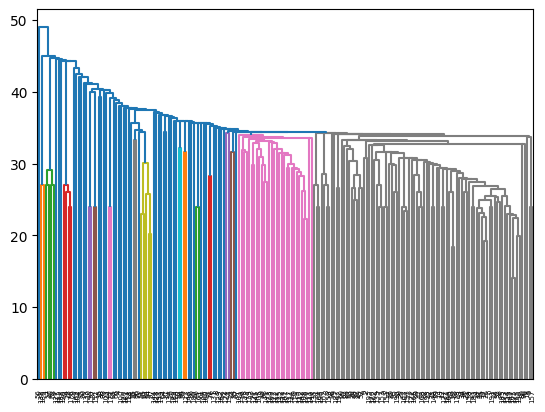

In [18]:
Z = hcluster.linkage(X)
dn = hcluster.dendrogram(Z)

In [57]:
clusters = hcluster.fclusterdata(X, 1)
print('Estimated number of clusters: %d' % len(set(clusters)))

Estimated number of clusters: 116


In [58]:
from sklearn.metrics.pairwise import cosine_similarity

for i in range(1, 117):
    one_cluster = np.where(clusters == i)
    mx = []
    cluster = X[one_cluster]
    if len(cluster) > 2:
        cl = np.mean(cluster, axis=0)
        sim = dict()
        for l, vec in enumerate(cluster):
            cos_sim = cosine_similarity([cl], [vec])[0][0]
            sim[l] = cos_sim
        for key in sorted(sim.values(), reverse=True)[:3]:
            mx.append(cluster[list(sim.keys())[list(sim.values()).index(key)]])
        print(f'Топ-3 элемента в кластере №{i}:')
        top = []
        for k in mx:
            for j, g in matr.items():
                if (g == k).all():
                    top.append(j)
        print(', '.join(top) + '\n')

Топ-3 элемента в кластере №4:
поменять_название, сменить_название, заменить_название

Топ-3 элемента в кластере №11:
заменить_слово, заменить_фраза, заменить_выражение

Топ-3 элемента в кластере №21:
изменить_система, заменить_система, изменить_структура

Топ-3 элемента в кластере №22:
изменить_обстановка, изменить_ситуация, изменить_настроение

Топ-3 элемента в кластере №24:
изменить_йота, изменить_внешность, изменить_неузнаваемость

Топ-3 элемента в кластере №35:
поменять_поза, сменить_поза, изменить_поза

Топ-3 элемента в кластере №36:
поменять_тактика, изменить_тактика, сменить_тактика

Топ-3 элемента в кластере №38:
заменить_казнь, заменить_расстрел, заменить_повешение

Топ-3 элемента в кластере №44:
поменять_фамилия, сменить_фамилия, изменить_фамилия

Топ-3 элемента в кластере №46:
заменить_кран, заменить_станок, заменить_машина

Топ-3 элемента в кластере №47:
поменять_владелец, сменить_владелец, поменять_собственник

Топ-3 элемента в кластере №48:
поменять_колесо, заменить_колес

In [59]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=116).fit(X)

In [60]:
from sklearn.metrics.pairwise import cosine_similarity

labels = kmeans.labels_
centroids = kmeans.cluster_centers_
for i, cl in enumerate(centroids):
    one_cluster = np.where(labels == i)
    mx = []
    cluster = X[one_cluster]
    if len(cluster) > 2:
        sim = dict()
        for l, vec in enumerate(cluster):
            cos_sim = cosine_similarity([cl], [vec])[0][0]
            sim[l] = cos_sim
        for key in sorted(sim.values(), reverse=True)[:3]:
            mx.append(cluster[list(sim.keys())[list(sim.values()).index(key)]])
        print(f'Топ-3 элемента в кластере №{i}:')
        top = []
        for k in mx:
            for j, g in matr.items():
                if (g == k).all():
                    top.append(j)
        print(', '.join(top) + '\n')

Топ-3 элемента в кластере №0:
поменять_владелец, сменить_владелец, поменять_собственник

Топ-3 элемента в кластере №3:
заменить_повешение, заменить_оброк, заменить_мать

Топ-3 элемента в кластере №9:
поменять_название, сменить_название, заменить_название

Топ-3 элемента в кластере №12:
поменять_мыло, поменять_ванная, поменять_шило

Топ-3 элемента в кластере №14:
заменить_слово, заменить_фраза, заменить_выражение

Топ-3 элемента в кластере №15:
поменять_фамилия, сменить_фамилия, изменить_фамилия

Топ-3 элемента в кластере №18:
заменить_кран, заменить_станок, поменять_кран

Топ-3 элемента в кластере №24:
поменять_поза, сменить_поза, изменить_поза

Топ-3 элемента в кластере №25:
изменить_убеждение, изменить_мнение, изменить_намерение

Топ-3 элемента в кластере №26:
поменять_тактика, сменить_тактика, изменить_тактика

Топ-3 элемента в кластере №33:
сменить_караул, сменить_часовой, сменить_дежурство

Топ-3 элемента в кластере №34:
заменить_лампочка, заменить_лампа, заменить_стекло

Топ-3 эл

116 кластеров в k-means, потому что так автоматически оценил метод иерархической кластеризации (при пороге 1: если его значение увеличить, то уже становится 1 кластер, если уменьшать, их количество быстро растёт)

группы получились в большинстве своём довольно однородные, а также похожие у обоих алгоритмов (например, группы №48 и №92: обе связаны с заменой шин/колёс в автомобиле; №35 и №24 со сменой позы и т.п.). можно увидеть и некоторые различия семантики глаголов: например, глагол "заменить" может иметь значение "заменить один предмет другим по сути, непохожим на него" (группы №98, №91, №11 и др.), а глаголы "сменить, поменять" - "заменить один предмет похожим, таким же по сути, но более новым/следующим по очереди и т.д." (группы №92, №73, №47, №56 и др.). Глагол "изменить" может иметь значение "качественно поменять сам предмет, изменить что-то в нём" (группы №86, №22, №21 и др.)